# Pre processing and data augmentaion

This notebook focuses on data pre processing and augmentation. All of these operations are made prior to model training. Pre-processed data is saved to separate directories, that the training loop will have access to.

In [58]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')

import src.preprocessing.preprocess as pr
import src.modules.plotting as p
import src.utils.dataset_helper as dh
import src.utils.data_splitter as ds

from importlib import reload

In [59]:
reload(pr);
reload(dh);
reload(p);
reload(ds);

- Get the helper and the pre processing static classes

In [60]:
helper = dh.DatasetHelper

- Get csv datasets

In [69]:
train_df = pd.read_csv('../data/csv/train_clean.csv')
val_df = pd.read_csv('../data/csv/validation.csv')
test_df = pd.read_csv('../data/csv/test.csv')

- Sort the train instances, in order to match the order of the image dataset

In [70]:
train_df = train_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)
val_df = val_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)
test_df = test_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)

- Declare the path of the directories that contains the image datasets

In [71]:
base_dir_train = os.path.join('..', 'data', 'train_freesurfers')
base_dir_test = os.path.join('..', 'data', 'test_freesurfers')
base_dir_val = os.path.join('..', 'data', 'validation_freesurfers')

- Declare the file names to pre-process

In [72]:
left_hippo = 'posterior_Left-Hippocampus.mgz'
#left_hippo = 'posterior_left_hippocampal_fissure.mgz'
left_hippo_processed = 'posterior_Left-Hippocampus.nii.gz'
#left_hippo_processed = 'posterior_left_hippocampal_fissure.nii.gz'

right_hippo = 'posterior_Right-Hippocampus.mgz'
#right_hippo = 'posterior_right_hippocampal_fissure.mgz'
right_hippo_processed = 'posterior_Right-Hippocampus.nii.gz'
#right_hippo_processed = 'posterior_right_hippocampal_fissure.nii.gz'

## Dataset definition for standard pre-processing

- Using the `get_datasets` API we retrieve for each set a dictionary containing the dataset for left and right hippocampus. These can be accessed using the 'left' and 'right' keywork


### Train datasets


In [73]:
train_datasets = pr.get_datasets(
    base_dir=base_dir_train, 
    experiments=train_df['MR_session'], 
    labels=train_df['label'], 
    left_file_name=left_hippo, 
    right_file_name=right_hippo
)

### Validation datasets

In [74]:
validation_datasets = pr.get_datasets(
    base_dir=base_dir_val, 
    experiments=val_df['MR_session'], 
    labels=val_df['label'],
    left_file_name=left_hippo, 
    right_file_name=right_hippo
)

### Test datasets


In [75]:
test_datasets = pr.get_datasets(
    base_dir=base_dir_test, 
    experiments=test_df['MR_session'], 
    labels=test_df['label'],
    left_file_name=left_hippo, 
    right_file_name=right_hippo
)

## Determine images final dimension

- To train a model every instance needs to have the same spatial size
- The data are by default cropped, which results in every instance having different shapes
- To correctly apply a resize operation at the very end of the pre processing pipeline, it is necessary to gather some more information about the maximum size of each image's dimension (after undergoing to a crop transform)

In [68]:
#pr.max_size_after_crop(train_datasets, validation_datasets, test_datasets)

In [ ]:
reload(pr)

<module 'src.preprocessing.preprocess' from 'c:\\Users\\giaco\\Documents\\Data Science projects\\alzheimer-mci-project\\notebooks\\..\\src\\preprocessing\\preprocess.py'>

In [79]:
SPATIAL_SIZE = (34, 48)

## Visualize pre-processed example

- A representation of how an image changes after preproccesing

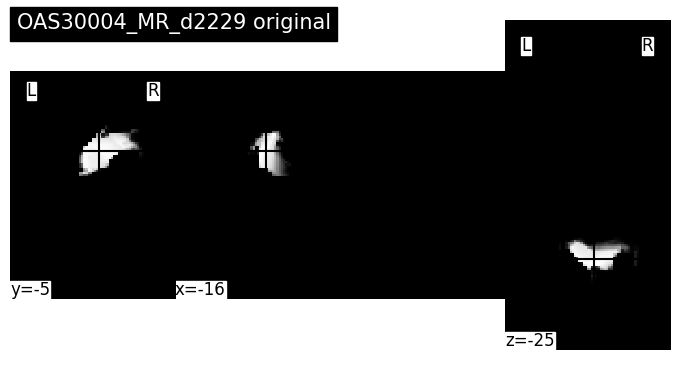

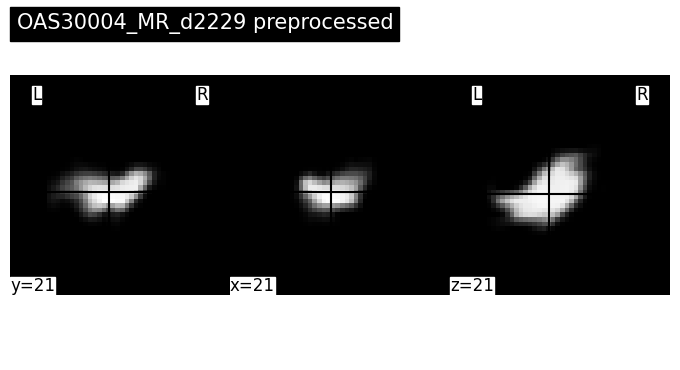

In [78]:
p.processed_example_comparison_plot(
    *pr.test_preprocessing(
        train_datasets['left'], 
        SPATIAL_SIZE, 
    )
)

## Execute Pre-processing

### Training set

In [84]:
pr.execute_pre_processing(
    save_dir_name='train_freesurfers_preprocess', 
    datasets=train_datasets, 
    spatial_size=SPATIAL_SIZE,
    left_file_name=left_hippo_processed,
    right_file_name=right_hippo_processed,
)

Processing left hippocampus:   0%|          | 0/878 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/878 [00:00<?, ?it/s]

### Validation set

In [85]:
pr.execute_pre_processing(
    save_dir_name='validation_freesurfers_preprocess', 
    datasets=validation_datasets, 
    spatial_size=SPATIAL_SIZE,
    left_file_name=left_hippo_processed,
    right_file_name=right_hippo_processed,
)

Processing left hippocampus:   0%|          | 0/172 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/172 [00:00<?, ?it/s]

### Test set

In [86]:
pr.execute_pre_processing(
    save_dir_name='test_freesurfers_preprocess', 
    datasets=test_datasets, 
    spatial_size=SPATIAL_SIZE,
    left_file_name=left_hippo_processed,
    right_file_name=right_hippo_processed,
)

Processing left hippocampus:   0%|          | 0/234 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/234 [00:00<?, ?it/s]

- Let's get a plot of a random pre-processed experiment to verify that data have been saved correctly

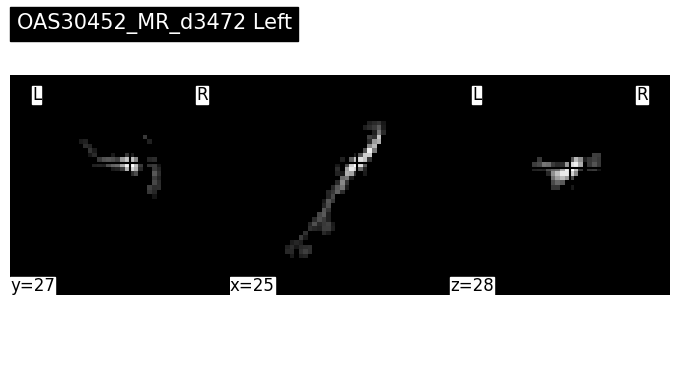

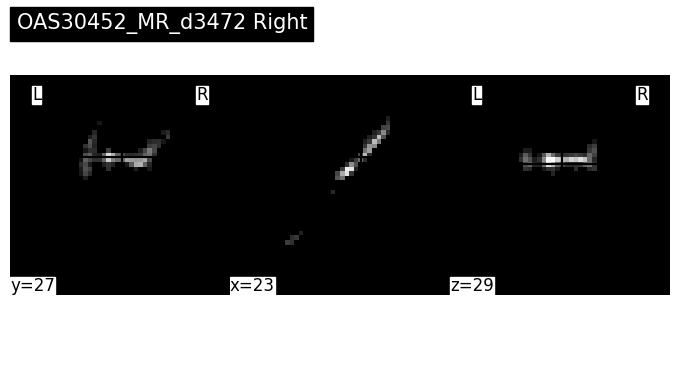

In [74]:
p.plot_img_by_experiment_id(
    dir=os.path.join('..', 'data', 'train_freesurfers_preprocess'),
    file_name_left=left_hippo_processed,
    file_name_right=right_hippo_processed,
    id=train_df['MR_session'].sample(n=1).to_list()[0]
)

## Train set augmentation
- In this section train and validation sets will be augmented with the operations defined in the previous notebook
- Let's load the training csv dataset where these additional instances are defined

In [87]:
full_train_set_df = pd.read_csv('../data/csv/train.csv')

- Sort the instances and drop cognitevely normal patients from the train set

In [89]:
full_train_set_df = (
    full_train_set_df
        .drop(
            columns='Unnamed: 0', 
            index=full_train_set_df[full_train_set_df['label'] == 'Non-Demented'].index
        )
        .sort_values(by='MR_session')
        .reset_index(drop=True)
)

- Drop instances that refer to NO augmentation in the train set

In [90]:
full_train_set_df = full_train_set_df.drop(
    index=full_train_set_df[full_train_set_df['augmentation'] == 'normal'].index
)

- Define sub-dataframe that will be the inpur for the pre-processing module

In [91]:
aug_mci_train_df = full_train_set_df[full_train_set_df['label'] == 'MCI']
aug_dem_train_df = full_train_set_df[full_train_set_df['label'] == 'Demented']

## Datasets definition for augmentation

- This section is dedicated in the definition of the datasets made with that instances that will be augmented
- The augmentation ids are defined here

In [94]:
augs = ['flip', 'rot30', 'rot60', 'rot90']

- To be consistent with the APIs of the `preprocessing` module we have to consider 4 different datasets, one for every different augmentation type (flip, rot30, rot90, ro150)
- A dictionary to improve the access of the datasets inside the lists created above

In [95]:
indexer = {aug: i for i, aug in enumerate(augs)}
indexer

{'flip': 0, 'rot30': 1, 'rot60': 2, 'rot90': 3}

- Augmentation operation dictionary

In [96]:
aug_ops = {
    'rot60': [pr.operations.get_rotation(60)],
    'rot30': [pr.operations.get_rotation(30)],
    'rot90': [pr.operations.get_rotation(90)],
    'flip': [pr.operations.FLIP]
}

### MCI dataset

- Datasets with MCI instances from the training set to augment:

In [101]:
mci_train_datasets = [
    pr.get_datasets(
        base_dir=base_dir_train, 
        experiments=aug_mci_train_df[aug_mci_train_df['augmentation'] == aug]['MR_session'], 
        labels=aug_mci_train_df[aug_mci_train_df['augmentation'] == aug]['label'],
        left_file_name=left_hippo, 
        right_file_name=right_hippo
    )
    for aug in augs 
    if aug != 'rot45'
]

#### Visualize a MCI augmentations example

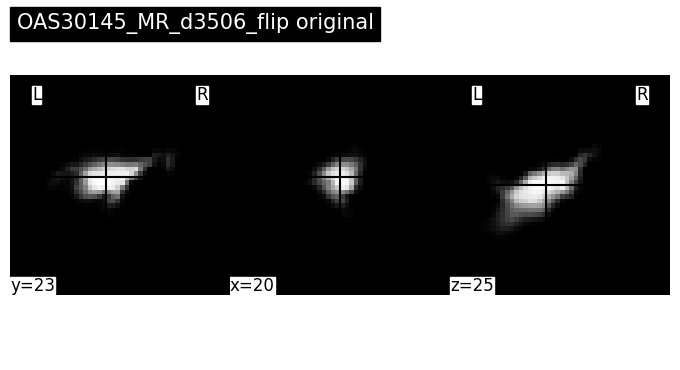

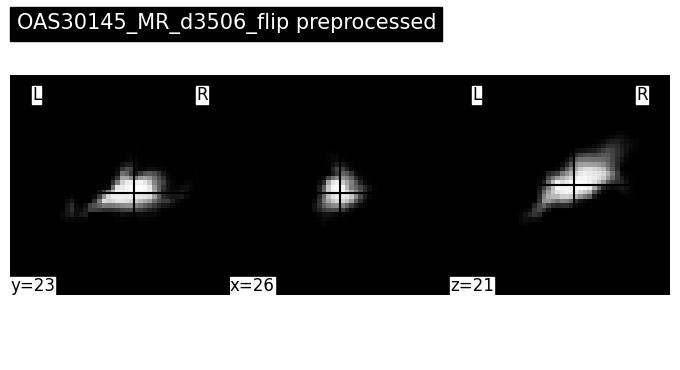

In [102]:
i = indexer['flip']

_, img_orig, exp = pr.test_preprocessing(mci_train_datasets[i]['left'], SPATIAL_SIZE)
_, img_proc, exp = pr.test_preprocessing(mci_train_datasets[i]['left'], SPATIAL_SIZE, aug_ops['flip'])

p.processed_example_comparison_plot(img_orig, img_proc, subject=exp)

### Demented dataset

- Datasets with Demented instances from the training set to augment:
    1. Only instances to flip
    2. Only instances to rotate by 150 degrees
    3. Only instances to rotate by 30 degrees
    4. Only instances to rotate by 90 degrees

In [ ]:
dem_train_datasets = [
    pr.get_datasets(
        base_dir=base_dir_train, 
        experiments=aug_dem_train_df[aug_dem_train_df['augmentation'] == aug]['MR_session'], 
        labels=aug_dem_train_df[aug_dem_train_df['augmentation'] == aug]['label'],
        left_file_name=left_hippo, 
        right_file_name=right_hippo
    )
    for aug in augs 
    if aug != 'rot45'
]

### Visualize the effect of a flip

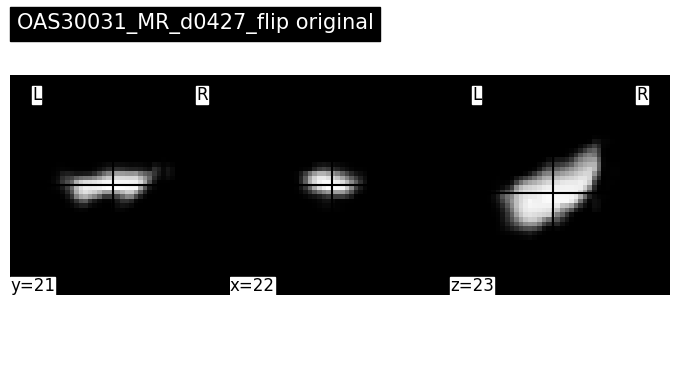

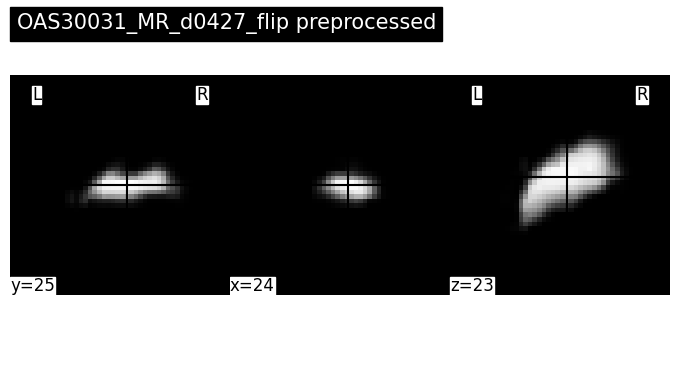

In [104]:
i = indexer['flip']

_, img_orig, exp = pr.test_preprocessing(dem_train_datasets[i]['left'], SPATIAL_SIZE)
_, img_proc, exp = pr.test_preprocessing(dem_train_datasets[i]['left'], SPATIAL_SIZE, aug_ops['flip'])

p.processed_example_comparison_plot(img_orig, img_proc, subject=exp)

## Executing Augmentation

### Train set MCI data

In [105]:
for aug in augs:
    print(aug)
    pr.execute_pre_processing(
        save_dir_name='train_freesurfers_preprocess',
        datasets=mci_train_datasets[indexer[aug]],
        spatial_size=SPATIAL_SIZE,
        additional_operations=aug_ops[aug],
        left_file_name=left_hippo_processed,
        right_file_name=right_hippo_processed,
    )

flip


Processing left hippocampus:   0%|          | 0/20 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/20 [00:00<?, ?it/s]

rot30


Processing left hippocampus:   0%|          | 0/20 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/20 [00:00<?, ?it/s]

rot60


Processing left hippocampus:   0%|          | 0/20 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/20 [00:00<?, ?it/s]

rot90


Processing left hippocampus:   0%|          | 0/20 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/20 [00:00<?, ?it/s]

- Visualize the results of MCI augmentation

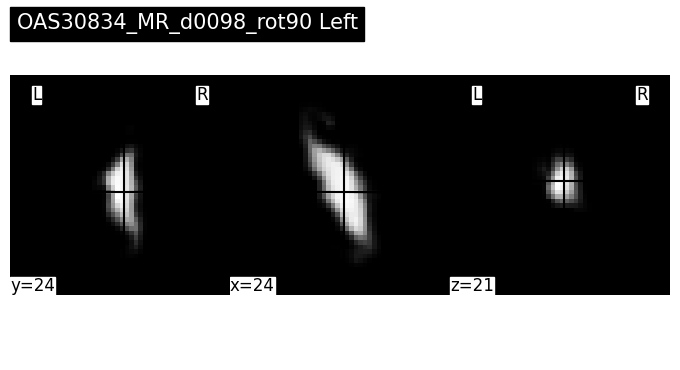

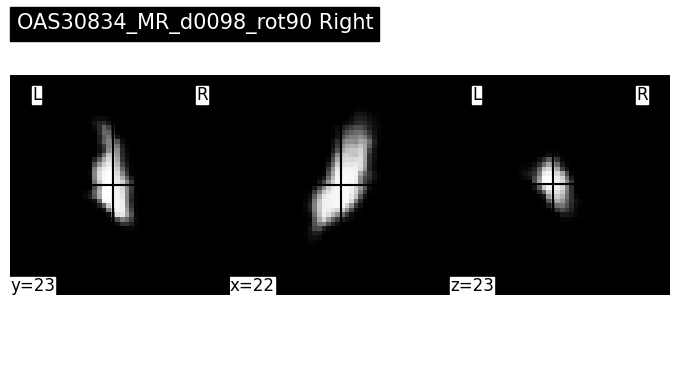

In [106]:
p.plot_img_by_experiment_id(
    dir=os.path.join('..', 'data', 'train_freesurfers_preprocess'),
    id=aug_mci_train_df['MR_session'].sample(n=1).to_list()[0],
    file_name_left=left_hippo_processed,
    file_name_right=right_hippo_processed
)

### Train set demented data

In [107]:
for aug in augs:
    print(aug)
    if aug != 'rot45':
        pr.execute_pre_processing(
            save_dir_name='train_freesurfers_preprocess',
            datasets=dem_train_datasets[indexer[aug]],
            spatial_size=SPATIAL_SIZE,
            additional_operations=aug_ops[aug],
            left_file_name=left_hippo_processed,
            right_file_name=right_hippo_processed,
        )

flip


Processing left hippocampus:   0%|          | 0/69 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/69 [00:00<?, ?it/s]

rot30


Processing left hippocampus:   0%|          | 0/69 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/69 [00:00<?, ?it/s]

rot60


Processing left hippocampus:   0%|          | 0/69 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/69 [00:00<?, ?it/s]

rot90


Processing left hippocampus:   0%|          | 0/69 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/69 [00:00<?, ?it/s]

- Visualize a random result of demented augmentation

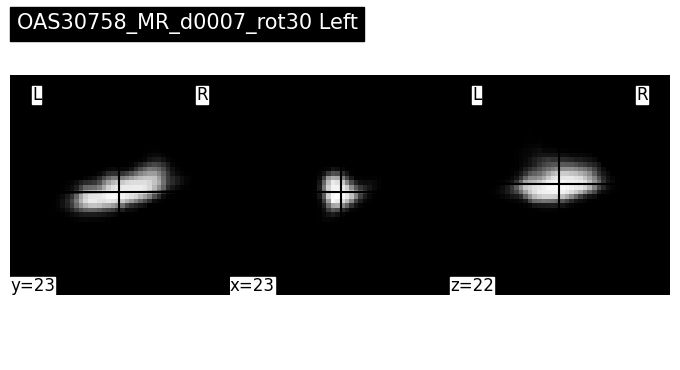

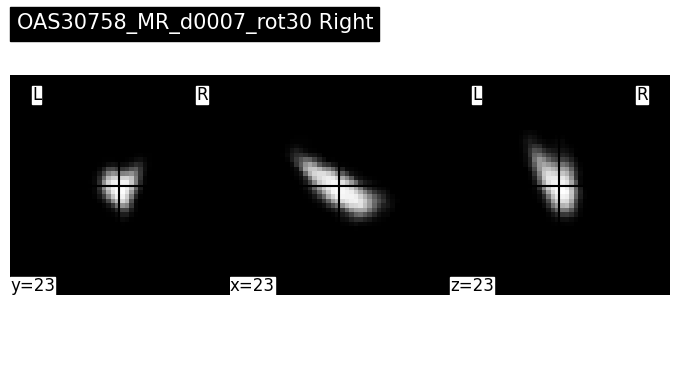

In [108]:
p.plot_img_by_experiment_id(
    dir=os.path.join('..', 'data', 'train_freesurfers_preprocess'),
    id=aug_dem_train_df['MR_session'].sample(n=1).to_list()[0],
    file_name_left=left_hippo_processed,
    file_name_right=right_hippo_processed
)